<a href="https://colab.research.google.com/github/dan-a-iancu/OIT248/blob/main/Diet_Problem/Optimal_Diets_and_Food_Security.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimal Diets and Food Security Mini-case**

This notebook implements a complete solution for the mini-case. It assumes that you are familiar with the context and have understood the basic models to build.

In [1]:
#@title **Basic Setup.**

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

#@markdown We start by importing a few useful modules and reading the case data in.
import numpy as np

import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 15)
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker

# install Gurobi (our linear optimization solver)
!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

# some modules to create local directories for CBC (to avoid issues with solving multiple models)
import os
def new_local_directory(name):
    full_path = os.path.join(".", name)
    os.makedirs(full_path, exist_ok=True)
    return full_path

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

Looking in indexes: https://pypi.gurobi.com
Completed successfully!


______

# Load the data and have a quick look

This downloads an Excel file with all the data from Github, and then reads in and stores the data in suitable dataframes.

In [2]:
#@markdown Load the data and take a quick look

url_Excel = 'https://raw.githubusercontent.com/dan-a-iancu/airm/master/Diet_Problem/Diet_Problem_Data.xlsx'
local_file = "Diet_Problem_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

foodData = pd.read_excel("Diet_Problem_Data.xlsx", index_col=0)   # read all the food data into a dataframe
#foodData = pd.read_excel("Food_Data_no_baby_food.xlsx", index_col=0)   # read all the food data into a dataframe
RDA = pd.read_excel("Diet_Problem_Data.xlsx", sheet_name = "RDA", index_col=0)
TUL = pd.read_excel("Diet_Problem_Data.xlsx", sheet_name = "TUL", index_col=0)

#foodData = pd.read_csv(url_foods, index_col=0, sep='\t', skip_blank_lines=True)   # read all the food data into a dataframe
#RDA = pd.read_csv("RDA.csv", index_col=0)
#TUL = pd.read_csv("TUL.csv", index_col=0)

# the list of all the foods (denoted by F in our model) : the row labels in the food data-frame
all_foods = list(foodData.index)

# the list of all the nutrients (denoted by N in our model) : the columns of the food data-frame
all_nutrients = list(foodData.columns)

# the list of all the nutrients that have RDAs specified : the columns of the RDA d-f
nutrients_with_RDA = list(RDA.columns)

# the list of all the nutrients that have TULs specified : the columns of the TUL d-f
nutrients_with_TUL = list(TUL.columns)
print("Done reading the data...")

# the list of all relevant nutrients (with RDA and/or TUL)
relevant_nutrients = list(set(nutrients_with_RDA + nutrients_with_TUL))

# the list of all life stages
Marco_life_stage = 'Males_31-50_y'   # this is Marco's life stage

#@markdown - print a few rows of the table with nutrient data
print("\nThis is the data on food ingredients:")
display(foodData)

#@markdown - print the RDA data relevant to Marco's age group
print("\nThis is the data on recommended dietary allowances (RDAs):")
display(RDA.loc[[Marco_life_stage,]])

#@markdown - print the TUL data relevant to Marco's age group
print("\nThis is the data on tolerable upper limits (TULs):")
display(TUL.loc[[Marco_life_stage,]])

Done reading the data...

This is the data on food ingredients:


,Main_food_description,Type,Price_($),Calories_kCal,Carbohydrate_g,Fiber_g,Protein_g,Calcium_mg,Copper_mg,Iron_mg,...,Vitamin_C_mg,Vitamin_D_microg,Vitamin_E_mg,Niacin_mg,Vitamin_B6_mg,Folate_microg,Choline_mg,Sugar_g,Lipid_g,Marco_Diet
1,"BUTTER,WITH SALT",Dairy,0.74,717,0.06,0.00,0.85,24,0.00,0.02,...,0.00,1.50,2.32,0.04,0.00,3,18.80,0.06,81.11,0.00
2,"CHEESE, CAMEMBERT",Dairy,1.89,300,0.46,0.00,19.80,388,0.02,0.33,...,0.00,0.40,0.21,0.63,0.23,62,15.40,0.46,24.26,1.00
3,"CHEESE, CHEDDAR",Dairy,0.90,403,1.28,0.00,24.90,721,0.03,0.68,...,0.00,0.60,0.29,0.08,0.07,18,16.50,0.52,33.14,0.00
4,"CHEESE, MOZZARELLA, WHOLE MILK",Dairy,1.01,300,2.19,0.00,22.17,505,0.01,0.44,...,0.00,0.40,0.19,0.10,0.04,7,15.40,1.03,22.35,0.00
5,"CHEESE, RICOTTA",Dairy,0.47,174,3.04,0.00,11.26,207,0.02,0.38,...,0.00,0.20,0.11,0.10,0.04,12,17.50,0.27,12.98,0.00
6,"MILK, SOY",Dairy,0.24,33,4.92,0.20,2.60,123,0.17,0.42,...,0.00,1.10,0.11,0.42,0.03,9,23.60,3.65,1.47,0.00
7,"MILK,RED FAT,FLUID,2% MILKFAT",Dairy,0.09,50,4.80,0.00,3.30,120,0.01,0.02,...,0.20,1.20,0.03,0.09,0.04,5,16.40,5.06,1.98,0.00
8,"MILK,LOWFAT,FLUID,1% MILKFAT",Dairy,0.10,42,4.99,0.00,3.37,125,0.01,0.03,...,0.00,1.20,0.01,0.09,0.04,5,17.70,5.20,0.97,0.00
9,"MILK, NONFAT, FLUID",Dairy,0.19,34,4.96,0.00,3.37,122,0.01,0.03,...,0.00,1.20,0.01,0.09,0.04,5,15.60,5.09,0.08,0.00
10,"MILK SHAKES,THICK CHOC",Dairy,0.25,119,21.15,0.30,3.05,132,0.07,0.31,...,0.00,1.00,0.05,0.12,0.03,5,17.00,20.85,2.70,0.00



This is the data on recommended dietary allowances (RDAs):


,Calories_kCal,Carbohydrate_g,Fiber_g,Protein_g,Calcium_mg,Copper_mg,Iron_mg,Phosphorus_mg,Zinc_mg,Potassium_mg,Sodium_mg
Males_31-50_y,2600,130,38,56,1000,0.90,8,700,11,4700,1500



This is the data on tolerable upper limits (TULs):


,Calcium_mg,Copper_mg,Iron_mg,Phosphorus_mg,Zinc_mg,Sodium_mg,Vitamin_A_mg,Vitamin_C_mg,Vitamin_D_microg,Vitamin_E_mg,Niacin_mg,Vitamin_B6_mg,Folate_microg,Choline_mg
Males_31-50_y,2500,10,45,4000,40,2300,3.00,2000,100,1000,35,100,1000,3500


____________

# **Q1**.

Implement the basic version of the model, which only involves the Recommended Dietary Allowances (RDA).

## The mathematical problem formulation
*Expand this section if you want to see how this optimization problem would be formalized mathematically.*

__Problem Parameters:__ Let us introduce some simple notation for all the data / parameters:
* $F= \{1,2,...,\}$ denotes the set of all the foods; we will use $f$ to refer to a specific food from this set (so $f$ will be a number like $1,2,3,...$);
* $N = \{"Calories", "Carbohydrates", ...\}$ denotes the set of all the nutrients and vitamins; we will use $n$ to denote a specific such nutrient/vitamin;
* $D_{f,n}$ denotes the content of nutrient $n$ in food type $f$ (in our data, these are expressed per 100 grams of the respective food);
* $P_f$ denotes the price of food $f$ (in our data, these are expressed per 100 grams of the respective food);
* $RDA_n$ denotes the Recommended Dietary Intake for nutrient $n$;
________

<font color=blue>__DECISION VARIABLES:__</font>  There is one decision variable for every food in our data. We let <font color=red>$Q_{f}$</font> denote the quantity of food of type $f$ consumed in the diet, expressed in 100g multiples. (So $Q_1 = 1.2$ would mean that 120g of food 1 is consumed).
_________

<font color=blue>__OBJECTIVE:__</font> Minimize the total cost of the diet, given by: $Q_1 \cdot P_1 \cdot Q_2 \cdot P_2 {} + ... $ More compactly: $\sum_{f \in F} Q_{f} \cdot P_f$.
____________

<font color=blue>__CONSTRAINTS:__</font> <br>

__MEETING RDA REQUIREMENT:__ For every nutrient $n$ that has an RDA specified, we need a constraint that ensures:
$$Q_1 \cdot D_{1,n} + Q_2 \cdot D_{2,n} + ... \geq RDA_n,$$
or more compactly: $\sum_{f \in F} Q_f \cdot D_{f,n} \geq  RDA_n$.

__NON-NEGATIVE DECISIONS:__ Our decision variables are the amounts of food we eat, so they must be non-negative: $X_f \geq 0$ for every $f$.
_______

## Create and solve the optimization model in Python
*Feel free to expand and sub-sections and show the code if you are curious to see how this problem is formulated in Python.*

### Create en empty model

Double-click the cell below if you are curious to see the code.

In [3]:
#@markdown Create an empty model

# the model is created with the function "Model", and we give it a meaningful name
myModel = Model("Optimal Diet Problem with RDA")
print("Done")

Restricted license - for non-production use only - expires 2024-10-28
Done


### Define and add decision variables

We need a decision for every food type, for the quantity of that food that we recommend in the diet; all decisions should be non-negative.

In [4]:
#@markdown Define and add the decision variables

# we create the decisions: note that we specify several arguments:
#   - the first argument is a list of strings corresponding to all the food names
#             This means a decision will be created for each element of the list (i.e., for every type of food)
#   - lb: used to specify a lower bound on the value of the decisions
#             Here, 0 makes all the decisions non-negative
#   - ub: if we want, we can also give an upper bound on the value of a decision
#             Here, we are skipping the upper bound
#   - vtype: the type of values the decision can take: GRB.CONTINUOUS is the default
#             Other options we'll use later are Integer or Binary
#   - name: is simply used internally, e.g., when displaying the model
#
# Here, we call our Python variables `quantity_consumed` instead of Q (as in the mathematical formulation)
# simply in order to make the model more readable
quantity_consumed = myModel.addVars(all_foods, lb = 0.0, vtype=GRB.CONTINUOUS, name = "Food")
print("Done")

Done


### Calculate and add the objective

The objective is to minimize the cost of the diet.

In [5]:
#@markdown Calculate the objective and add it into the model
cost = quicksum( quantity_consumed[f]*foodData.loc[f,"Price_($)"] for f in all_foods)
myModel.setObjective(cost, GRB.MINIMIZE)

print("Done")

Done


### Calculate and add the constraints

Calculate the left- and right-hand-sides for all the constraints, and add the constraints to the model. Here, we need to add a constraint for every nutrient that has a valid RDA specified.

In [6]:
#@markdown Calculate the constraints and add them to the model
RDA_con = {}

# Add constraints for each nutrient that has an RDA specified
# Note that we are naming the constraint using the nutrient name
for n in nutrients_with_RDA :
    RDA_con[n] = myModel.addConstr(  quicksum( quantity_consumed[f]*foodData.loc[f,n] for f in all_foods ) \
                                   >= RDA.loc[Marco_life_stage,n], name = "RDA_{}".format(n) )
print("Done adding constraints!")

Done adding constraints!


### Inspect the model


You can actually write the model out, which is useful for inspection. In this case the LP file may become large, so the code is commented out below. Feel free to un-comment the second line to see the output.

In [7]:
#@markdown Feel free to uncomment the next lines if you want to see the model printed
myModel.write("myModel.lp")    # write the model to a file with extension ".lp"
f = open("myModel.lp", 'r')    # open a file handle
print( f.read() )           # read the contents and print them
f.close()              # close the file handle

\ Model Optimal Diet Problem with RDA
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  0.744165499635192 Food[1] + 1.894856881126608 Food[2]
   + 0.9011596612711262 Food[3] + 1.007517365918331 Food[4]
   + 0.4667685203860052 Food[5] + 0.2441850909871593 Food[6]
   + 0.0942478350253495 Food[7] + 0.0962185779163782 Food[8]
   + 0.1856593015901763 Food[9] + 0.2472415223044393 Food[10]
   + 0.2480330674851011 Food[11] + 0.4042711636876137 Food[12]
   + 0.2973505754723765 Food[13] + 0.4422123400205002 Food[14]
   + 0.5111760241214136 Food[15] + 0.7770792499099578 Food[16]
   + 0.255552086538702 Food[17] + 1.000181170150418 Food[18]
   + 0.5252177603933039 Food[19] + 0.4596535469326503 Food[20]
   + 0.3543043907547627 Food[21] + 0.3543043907547627 Food[22]
   + 3.30174219415972 Food[23] + 0.3522506187156488 Food[24]
   + 0.2302035523424423 Food[25] + 0.6839046745223016 Food[26]
   + 0.4042711636876058 Food[27] + 1.146776770674179 Food[28]
   + 0.60298

### Solve the model and display the status of the optimization

In [8]:
#@markdown Solve the model

#@markdown <br> - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = False #@param {type:"boolean"}

if run_silently:
    myModel.setParam('OutputFlag',0)
else:
    myModel.setParam('OutputFlag',1)

myModel.optimize()
print('Done with the optimization...')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 11 rows, 70 columns and 720 nonzeros
Model fingerprint: 0xb2cd5a92
Coefficient statistics:
  Matrix range     [4e-03, 1e+03]
  Objective range  [5e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 5e+03]
Presolve removed 0 rows and 17 columns
Presolve time: 0.01s
Presolved: 11 rows, 53 columns, 545 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.260250e+02   0.000000e+00      0s
       6    1.9965653e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.996565317e+00
Done with the optimization...


### Display the solution


We only print out the foods that are actually consumed, i.e., that involve an optimal quantity > 0.

In [9]:
#@markdown Display the optimal decisions and optimal objective
if myModel.status==GRB.OPTIMAL:
    print("\nThe diet consists of:")
    for f in all_foods:
        if quantity_consumed[f].X > 0 :
            print("\t Food {:2} ({:<30s}) : {:<.1f} (grams)".\
                  format(f, foodData.loc[f,"Main_food_description"], \
                         quantity_consumed[f].X * 100))

    print("\nDaily cost of the diet: ${:.3f} ".format(myModel.objVal))
    print("Annualized cost of the diet: ${:.2f} ".format(myModel.objVal*365))

elif myModel.status==GRB.INFEASIBLE:
  print("The problem is infeasible.")

elif myModel.status==GRB.UNBOUNDED:
  print("The problem is unbounded.")


The diet consists of:
	 Food  8 (MILK,LOWFAT,FLUID,1% MILKFAT  ) : 211.7 (grams)
	 Food 54 (POTATO, RAW                   ) : 272.7 (grams)
	 Food 56 (TOMATO CATSUP                 ) : 139.9 (grams)
	 Food 63 (RICE, WHITE                   ) : 2429.4 (grams)

Daily cost of the diet: $1.997 
Annualized cost of the diet: $728.75 


To interpret the solution, let us calculate the daily intake of each nutrient, and compare with the RDA. We also calculate the food that is most cost-effective for each nutrient (i.e., delivers the largest nutrient per dollar spent).

In [10]:
#@markdown Inspect the solution
# Let's construct a data frame that prints the status of all the constraints
allConstraints = myModel.getConstrs()
constraint_status = [ [c.ConstrName, myModel.getRow(c).getValue(), c.Sense, c.RHS, c.Slack] for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(constraint_status, columns=["Constraint Name", "Daily Intake", "Sense", "Daily RDA", "Slack"])
display(df)

,Constraint Name,Daily Intake,Sense,Daily RDA,Slack
0,RDA_Calories_kCal,"9,322.76",>,"2,600.00","-6,722.76"
1,RDA_Carbohydrate_g,"2,037.18",>,130.00,"-1,907.18"
2,RDA_Fiber_g,38.00,>,38.00,0.00
3,RDA_Protein_g,187.61,>,56.00,-131.61
4,RDA_Calcium_mg,"1,000.00",>,"1,000.00",0.00
5,RDA_Copper_mg,5.84,>,0.90,-4.94
6,RDA_Iron_mg,107.47,>,8.00,-99.47
7,RDA_Phosphorus_mg,"3,189.51",>,700.00,"-2,489.51"
8,RDA_Zinc_mg,28.50,>,11.00,-17.50
9,RDA_Potassium_mg,"4,700.00",>,"4,700.00",0.00


In [11]:
# save a few things for future use
# all the daily RDA values (for cases without RDA, put a 0)
daily_RDA_vals = [ RDA.loc[Marco_life_stage,n] if n in nutrients_with_RDA else 0 \
                  for n in relevant_nutrients]
# all the TULs (cases without TUL, put +inf)
daily_TUL_vals = [TUL[n][Marco_life_stage] if n in nutrients_with_TUL else np.Inf \
                  for n in relevant_nutrients]
# intakes from Q1 for all the relevant nutrients (ie, those with RDA or TUL)
daily_intake_vals_Q1 = [sum(quantity_consumed[f].X*foodData.loc[f,n] \
                     for f in all_foods) for n in relevant_nutrients]

____________

# **Q2**.

Determine which food is the most cost-effective for each macro-nutrient or vitamin with an RDA.

*This section assumes that you have already run all the sections before, and particularly **Q1**. If that is not the case, please re-run everything above (e.g., by selecting this cell and choosing **Runtime > Run before**).*

In [12]:
#@markdown Calculate the most cost-effective foods
cost_eff_foods = [ foodData.iloc[(foodData[n]/foodData["Price_($)"]).argmax(),0] for n in nutrients_with_RDA ]

# we can actually add the list above to the dataframe we constructed above
df["Most Cost-effective"] = cost_eff_foods

display(df)

,Constraint Name,Daily Intake,Sense,Daily RDA,Slack,Most Cost-effective
0,RDA_Calories_kCal,"9,322.76",>,"2,600.00","-6,722.76","RICE, WHITE"
1,RDA_Carbohydrate_g,"2,037.18",>,130.00,"-1,907.18","RICE, WHITE"
2,RDA_Fiber_g,38.00,>,38.00,0.00,ALL-BRAN
3,RDA_Protein_g,187.61,>,56.00,-131.61,"RICE, WHITE"
4,RDA_Calcium_mg,"1,000.00",>,"1,000.00",0.00,"MILK,LOWFAT,FLUID,1% MILKFAT"
5,RDA_Copper_mg,5.84,>,0.90,-4.94,"RICE, WHITE"
6,RDA_Iron_mg,107.47,>,8.00,-99.47,"RICE, WHITE"
7,RDA_Phosphorus_mg,"3,189.51",>,700.00,"-2,489.51","RICE, WHITE"
8,RDA_Zinc_mg,28.50,>,11.00,-17.50,"RICE, WHITE"
9,RDA_Potassium_mg,"4,700.00",>,"4,700.00",0.00,"POTATO, RAW"


____________

# **Q3**.

Design a minimal-cost diet that also meets all the tolerable upper limits (TUL).

*This section assumes that you have already run all the sections before. If that is not the case, please re-run everything above, e.g., by selecting this cell and choosing **Runtime > Run before**.*

In [13]:
#@title Create an optimization model like in **Q1**, but with TUL constraints

# create an empty model
myModel_Q3 = Model("Optimal Diet Problem with RDA and TUL")

# add variables
quantity_consumed_Q3 = myModel_Q3.addVars(all_foods, lb = 0.0, name = "Food")

# calculate the cost using the quicksum(.) function
cost_Q3 = quicksum( quantity_consumed_Q3[f]*foodData.loc[f,"Price_($)"] for f in all_foods)
myModel_Q3.setObjective(cost_Q3, GRB.MINIMIZE)

# add constraints for RDAs
for n in nutrients_with_RDA :
    myModel_Q3.addConstr(  quicksum( quantity_consumed_Q3[f]*foodData.loc[f,n] for f in all_foods ) \
                      >= RDA.loc[Marco_life_stage,n], name = "RDA_{}".format(n))

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    myModel_Q3.addConstr(  quicksum( quantity_consumed_Q3[f]*foodData.loc[f,n] for f in all_foods ) \
                      <= TUL.loc[Marco_life_stage,n], name = "TUL_%s" % n )

# if we want, print out the optimization model
#myModel_Q3.write("myModel_Q3.lp")    # write the model to a file with extension ".lp"
#f = open("myModel_Q3.lp", 'r')    # open a file handle
#print( f.read() )           # read the contents and print them
#f.close()              # close the file handle

#@markdown <br> - select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = False #@param {type:"boolean"}

if run_silently:
    myModel_Q3.setParam('OutputFlag',0)
else:
    myModel_Q3.setParam('OutputFlag',1)

print("Done creating the model.")
print("Proceeding to solve...")

myModel_Q3.optimize()

Done creating the model.
Proceeding to solve...
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 25 rows, 70 columns and 1594 nonzeros
Model fingerprint: 0x9492e938
Coefficient statistics:
  Matrix range     [3e-03, 2e+04]
  Objective range  [5e-02, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 5e+03]
Presolve removed 10 rows and 0 columns
Presolve time: 0.01s
Presolved: 15 rows, 73 columns, 987 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.658000e+02   0.000000e+00      0s

Solved in 29 iterations and 0.02 seconds (0.00 work units)
Infeasible model


__Surprisingly, the output above informs us that the model is <font color=red>infeasible</font>__. In other words, there is no possible combination of foods that simultaneously satisfies all the constraints that we added (RDAs and TULs). In Gurobi, it is possible to calculate and display a small set of constraints that make the model infeasible.

# **Q4**
Examine a few ways to resolve the problems we encountered in **Q3**.

## Q4-a
To see if there are data problems, let's try a diet that consumes 0.1 grams of each food!

In [14]:
#@title Try a diet with very small quantities of food
# the amount of food
tiny_bit_of_food = 0.1/100  # /100 because we want 100g multiples

# calculate the intake of each nutrient that has a TUL and compare with the TUL
for n in nutrients_with_TUL:
    print(f"Intake for {n:<20s}: \
    {sum(foodData.loc[f,n] for f in all_foods)*tiny_bit_of_food:.3f} \
    <  TUL : {TUL.loc[Marco_life_stage,n]}")

Intake for Calcium_mg          :     6.455     <  TUL : 2500
Intake for Copper_mg           :     0.006     <  TUL : 10
Intake for Iron_mg             :     0.138     <  TUL : 45
Intake for Phosphorus_mg       :     8.559     <  TUL : 4000
Intake for Zinc_mg             :     0.077     <  TUL : 40
Intake for Sodium_mg           :     17.135     <  TUL : 2300
Intake for Vitamin_A_mg        :     68.880     <  TUL : 3.0
Intake for Vitamin_C_mg        :     0.444     <  TUL : 2000
Intake for Vitamin_D_microg    :     0.039     <  TUL : 100
Intake for Vitamin_E_mg        :     0.100     <  TUL : 1000
Intake for Niacin_mg           :     0.143     <  TUL : 35
Intake for Vitamin_B6_mg       :     0.025     <  TUL : 100
Intake for Folate_microg       :     4.364     <  TUL : 1000
Intake for Choline_mg          :     1.947     <  TUL : 3500


The code above clearly points towards a problem with the **Vitamin_A** constraint! In fact, the data there is erroneous -- the amounts of Vitamin A in the foods should be several orders of magnitude smaller!

## Q4-b
In real-world models, it can well happen that everything is correct but the model is still infeasible. Let's print out a small set of constraints that make the model infeasible!

In [20]:
#@markdown Print a set of constraints that make the model infeasible
myModel_Q3.computeIIS()  # compute a small set of constraints that make the model infeasible

allConstraints = myModel_Q3.getConstrs()
all_constr_data = [ [c.ConstrName, myModel_Q3.getRow(c).getValue(), c.Sense, \
                     c.RHS, c.Slack, c.IISConstr] for c in allConstraints ]

# convert into a dataframe and print
df = pd.DataFrame(all_constr_data, columns=["Constraint Name", "LHS Value", \
                                            "Sense", "RHS Value", "Slack", "IIS"])
display(df)


IIS computed: 7 constraints and 63 bounds
IIS runtime: 0.00 seconds (0.00 work units)


,Constraint Name,LHS Value,Sense,RHS Value,Slack,IIS
0,RDA_Calories_kCal,"865,529.88",>,"2,600.00","-862,929.88",0
1,RDA_Carbohydrate_g,-0.17,>,130.00,130.17,0
2,RDA_Fiber_g,38.00,>,38.00,0.00,1
3,RDA_Protein_g,83.91,>,56.00,-27.91,0
4,RDA_Calcium_mg,"1,000.00",>,"1,000.00",0.00,1
...,...,...,...,...,...,...
20,TUL_Vitamin_E_mg,"14,045.35",<,"1,000.00","-13,045.35",0
21,TUL_Niacin_mg,16.94,<,35.00,18.06,0
22,TUL_Vitamin_B6_mg,5.57,<,100.00,94.43,0
23,TUL_Folate_microg,"1,000.00",<,"1,000.00",0.00,1


The output above suggests that the RDA for __Fiber, Calcium, Zinc__ combined with the TUL for __Iron, Sodium, Vitamin A and Folate__ make the problem infeasible. To restore feasibility, we could remove or relax some of these constraints. Note that by definition, removing **a single** one of these constraints is **guaranteed** to give a feasible problem.

Since the optimization problem in **Q3** is infeasible, the only way to resolve the issue is by relaxing or removing a few of the constraints. The code below explores a few different options.

In [16]:
#@title Select which constraints to **remove** from the model by ticking the boxes below:

# an empty model
myModel_Q4 = Model("Optimal_Diet_Problem_Q4")

# decision variables
quantity_consumed_Q4 = myModel_Q4.addVars(all_foods, lb = 0.0, name = "Food")

# calculate the cost using the quicksum(.) function
cost_Q4 = quicksum( quantity_consumed_Q4[f]*foodData["Price_($)"][f] for f in all_foods)
myModel_Q4.setObjective(cost_Q4, GRB.MINIMIZE)

remove_RDA = {}

#@markdown <br> **RDA (recommended dietary allowances) constraints**:
remove_all_RDA = False #@param {type:"boolean"}
remove_RDA_Calories = False #@param {type:"boolean"}
remove_RDA_Carbohydrate = False #@param {type:"boolean"}
remove_RDA_Fiber = False #@param {type:"boolean"}
remove_RDA_Protein = False #@param {type:"boolean"}
remove_RDA_Calcium = False #@param {type:"boolean"}
remove_RDA_Copper = False #@param {type:"boolean"}
remove_RDA_Iron = False #@param {type:"boolean"}
remove_RDA_Phosphorus = False #@param {type:"boolean"}
remove_RDA_Zinc = False #@param {type:"boolean"}
remove_RDA_Potassium = False #@param {type:"boolean"}
remove_RDA_Sodium = False #@param {type:"boolean"}

remove_TUL = {}
#@markdown <br>**TUL (tolerable upper limit) constraints:**
remove_all_TUL = False #@param {type:"boolean"}
remove_TUL_Calcium = False #@param {type:"boolean"}
remove_TUL_Copper = False #@param {type:"boolean"}
remove_TUL_Iron = False #@param {type:"boolean"}
remove_TUL_Phosphorus = False #@param {type:"boolean"}
remove_TUL_Zinc = False #@param {type:"boolean"}
remove_TUL_Sodium = False #@param {type:"boolean"}
remove_TUL_Vitamin_A = True #@param {type:"boolean"}
remove_TUL_Vitamin_C = False #@param {type:"boolean"}
remove_TUL_Vitamin_D = False #@param {type:"boolean"}
remove_TUL_Vitamin_E = False #@param {type:"boolean"}
remove_TUL_Niacin = False #@param {type:"boolean"}
remove_TUL_Vitamin_B6 = False #@param {type:"boolean"}
remove_TUL_Folate = False #@param {type:"boolean"}
remove_TUL_Choline = False #@param {type:"boolean"}

# constraints for all the RDAs
for n in nutrients_with_RDA :
    if remove_all_RDA==False and (eval("remove_RDA_" + n.rsplit("_", maxsplit=1)[0])==False):
        myModel_Q4.addConstr(  quicksum( quantity_consumed_Q4[f]*foodData.loc[f,n] for f in all_foods ) \
                >= RDA.loc[Marco_life_stage,n], name = "RDA_{}".format(n))

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    if remove_all_TUL==False and (eval("remove_TUL_" + n.rsplit("_", maxsplit=1)[0])==False):
        myModel_Q4.addConstr(  quicksum( quantity_consumed_Q4[f]*foodData.loc[f,n] for f in all_foods ) \
                      <= TUL.loc[Marco_life_stage,n], name = "TUL_%s" % n )

print("Done creating the model.")
print("Proceeding to solve...")

#@markdown <br> Optional flag to run the optimization algorithms silently:
run_silently = True #@param {type:"boolean"}

if run_silently:
    myModel_Q4.setParam('OutputFlag',0)
else:
    myModel_Q4.setParam('OutputFlag',1)

# solve the model and display the status
myModel_Q4.optimize()

tol_constraints = 1e-4

#@markdown <br>If the problem is feasible, display information about the solution, comparing it with Q1
if myModel_Q4.status==GRB.OPTIMAL:

    daily_RDA_vals = [RDA.loc[Marco_life_stage,n] if n in nutrients_with_RDA else 0 \
                      for n in relevant_nutrients]
    daily_intake_vals_Q4 = [sum(quantity_consumed_Q4[f].X*foodData.loc[f,n] \
                        for f in all_foods) for n in relevant_nutrients]
    daily_TUL_vals = [TUL.loc[Marco_life_stage,n] if n in nutrients_with_TUL else np.Inf \
                      for n in relevant_nutrients]

    Q4_below_RDA = [ 100*(daily_intake_vals_Q4[i] / daily_RDA_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] < daily_RDA_vals[i] - tol_constraints else 0 \
                  for i in range(len(relevant_nutrients)) ]

    Q4_exceed_TUL = [ 100*(daily_intake_vals_Q4[i] / daily_TUL_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] > daily_TUL_vals[i] + tol_constraints else 0 \
                  for i in range(len(relevant_nutrients))]

    df_with_TUL_Q4 = pd.DataFrame.from_dict( {"Nutrient" : relevant_nutrients, \
                                              "RDA" : daily_RDA_vals,\
                                              "TUL" : daily_TUL_vals,\
                                              "Actual Intake in Q1" : daily_intake_vals_Q1,\
                                              "Actual Intake in Q4" : daily_intake_vals_Q4,\
                                              "Above TUL(%)" : Q4_exceed_TUL,\
                                              } )
    #pd.set_option('display.max_rows', df_with_TUL_Q4.shape[0]+1)
    #pd.set_option('display.max_columns', df_with_TUL_Q4.shape[1]+1)
    display(df_with_TUL_Q4)

Done creating the model.
Proceeding to solve...


,Nutrient,RDA,TUL,Actual Intake in Q1,Actual Intake in Q4,Above TUL(%)
0,Protein_g,56.00,inf,187.61,56.00,0.00
1,Iron_mg,8.00,45.00,107.47,22.98,0.00
2,Vitamin_E_mg,0.00,"1,000.00",4.76,9.10,0.00
3,Calories_kCal,"2,600.00",inf,"9,322.76","2,600.00",0.00
4,Niacin_mg,0.00,35.00,106.92,26.21,0.00
5,Vitamin_C_mg,0.00,"2,000.00",59.45,225.90,0.00
6,Choline_mg,0.00,"3,500.00",228.86,288.37,0.00
7,Vitamin_D_microg,0.00,100.00,2.54,4.08,0.00
8,Vitamin_A_mg,0.00,3.00,"1,138.21","4,396.42","146,447.47"
9,Folate_microg,0.00,"1,000.00","5,678.64","1,000.00",0.00


In [17]:
#@title Select a tolerance (in %) by which to relax **all** the constraints (RDA and TUL):

#@markdown <br> **RDA (recommended dietary allowances) constraints**:
tolerance_for_relaxing_constraints = 8 #@param {type:"number"}
tol = max(0,tolerance_for_relaxing_constraints/100)

# an empty model
myModel_Q4 = Model("Optimal_Diet_Problem_Q4")

# decision variables
quantity_consumed_Q4 = myModel_Q4.addVars(all_foods, lb = 0.0, name = "Food")

# calculate the cost using the quicksum(.) function
cost_Q4 = quicksum( quantity_consumed_Q4[f]*foodData["Price_($)"][f] for f in all_foods)
myModel_Q4.setObjective(cost_Q4, GRB.MINIMIZE)

# constraints for all the RDAs
for n in nutrients_with_RDA :
    myModel_Q4.addConstr(  quicksum( quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods ) \
            >= RDA[n][Marco_life_stage]*(1-tol), name = "RDA_{}".format(n))

# add constraints for tolerable upper limits (TUL)
for n in nutrients_with_TUL:
    myModel_Q4.addConstr(  quicksum( quantity_consumed_Q4[f]*foodData[n][f] for f in all_foods ) \
                  <= TUL[n][Marco_life_stage]*(1+tol), name = "TUL_{}".format(n) )

# if we want, print out the optimization model
# print(myModel)

print("Done creating the model.")
print("Proceeding to solve...")

#@markdown <br> Optional flag to run the optimization algorithms silently:
run_silently = True #@param {type:"boolean"}

if run_silently:
    myModel_Q4.setParam('OutputFlag',0)
else:
    myModel_Q4.setParam('OutputFlag',1)

# solve the model and display the status
myModel_Q4.optimize()

tol_constraints = 1e-4

#@markdown <br>If the problem is feasible, display information about the solution, comparing it with Q1
if myModel_Q4.status==GRB.OPTIMAL:

    print("Optimized successfully. Objective value: {:.3f}".format(myModel_Q4.objVal))

    daily_RDA_vals = [RDA[n][Marco_life_stage] if n in nutrients_with_RDA else 0 \
                      for n in relevant_nutrients]
    daily_intake_vals_Q4 = [sum(quantity_consumed_Q4[f].X*foodData[n][f] \
                        for f in all_foods) for n in relevant_nutrients]
    daily_TUL_vals = [TUL[n][Marco_life_stage] if n in nutrients_with_TUL else np.Inf \
                      for n in relevant_nutrients]

    Q4_below_RDA = [ 100*(daily_intake_vals_Q4[i] / daily_RDA_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] < daily_RDA_vals[i] - tol_constraints else 0 \
                  for i in range(len(relevant_nutrients)) ]

    Q4_exceed_TUL = [ 100*(daily_intake_vals_Q4[i] / daily_TUL_vals[i] - 1.0) if \
                    daily_intake_vals_Q4[i] > daily_TUL_vals[i] + tol_constraints else 0 \
                  for i in range(len(relevant_nutrients))]

    df_with_TUL_Q4 = pd.DataFrame.from_dict( {"Nutrient" : relevant_nutrients, \
                                              "RDA" : daily_RDA_vals,\
                                              "TUL" : daily_TUL_vals,\
                                              "Actual Intake in Q4" : daily_intake_vals_Q4,\
                                              "Under RDA(%)" : Q4_below_RDA,\
                                              "Above TUL(%)" : Q4_exceed_TUL,\
                                              } )
    pd.set_option('display.max_rows', df_with_TUL_Q4.shape[0]+1)
    display(df_with_TUL_Q4)

Done creating the model.
Proceeding to solve...
Optimized successfully. Objective value: 15.945


,Nutrient,RDA,TUL,Actual Intake in Q4,Under RDA(%),Above TUL(%)
0,Protein_g,56.00,inf,82.98,0.00,0.00
1,Iron_mg,8.00,45.00,16.04,0.00,0.00
2,Vitamin_E_mg,0.00,"1,000.00",47.36,0.00,0.00
3,Calories_kCal,"2,600.00",inf,"2,392.00",-8.00,0.00
4,Niacin_mg,0.00,35.00,26.33,0.00,0.00
5,Vitamin_C_mg,0.00,"2,000.00",654.54,0.00,0.00
6,Choline_mg,0.00,"3,500.00",740.07,0.00,0.00
7,Vitamin_D_microg,0.00,100.00,1.19,0.00,0.00
8,Vitamin_A_mg,0.00,3.00,3.24,0.00,8.00
9,Folate_microg,0.00,"1,000.00","1,080.00",0.00,8.00


# **Q5**

Ana's alternative models.

## Q5-a. A Model with Squared Differences

This model is quite similar to the one you built in **Q1**, with a few differences:
- the objective is to minimize the distance between the recommended diet and Marco's current diet, where the distance is calculated as the *sum of squared differences in the foods consumed*:
> $\sum_{f \in \mbox{Foods}}$ (Recommended consumption of food $f$ - Current consumption of food $f$)$^2$
- there is a constraint that the cost of the recommended diet should not exceed a daily budget of \$5

Done creating the model.
Proceeding to solve...

Total difference from Marco's diet (in grams): 23.055.


Here are the old and the new diet side-by-side:
 Food                                 Name  Old Diet  New Diet
    2                    CHEESE, CAMEMBERT    100.00      0.00
    7        MILK,RED FAT,FLUID,2% MILKFAT      0.00     32.51
    8         MILK,LOWFAT,FLUID,1% MILKFAT      0.00     34.76
   10               MILK SHAKES,THICK CHOC      0.00     19.64
   12                YOGURT, FRUIT, LOWFAT    150.00     81.67
   14              EGG, WHITE ONLY, COOKED    200.00    104.95
   17                       DULCE DE LECHE     20.00    125.97
   24 OIL,SUNFLOWER,LINOLEIC,(APPROX. 65%)      0.00      9.71
   25             MARGARINE, STICK, SALTED      0.00     38.37
   31        CHICKEN BREAST  OVEN-ROASTED     250.00      0.00
   32                             ALL-BRAN      0.00    154.26
   34                           APPLE, RAW     50.00      0.00
   36                      

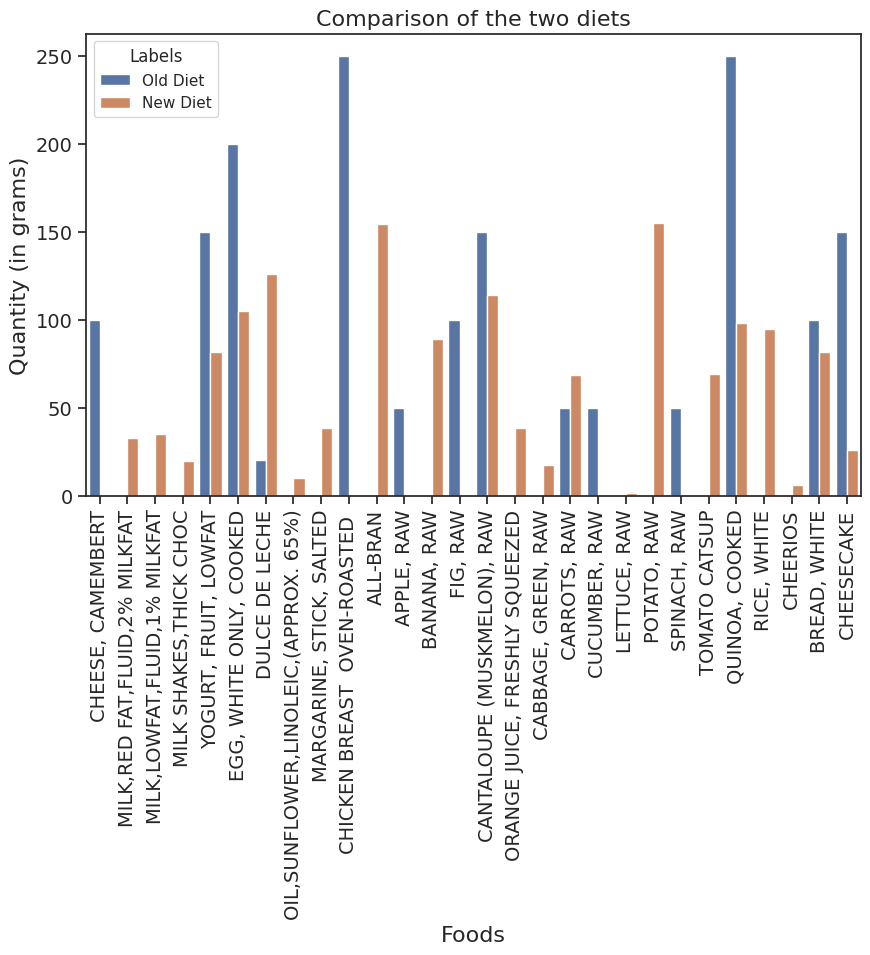

In [18]:
#@title Construct the model
daily_Budget = 5 # daily budget of $5

# create an empty model
myModel_Q5 = Model("Optimal Diet Problem with RDA and TUL")

# add variables
quantity_consumed_Q5 = myModel_Q5.addVars(all_foods, lb = 0.0, name = "Food")

# calculate and add the objective: minimize total squared difference
total_difference = quicksum( (quantity_consumed_Q5[f] - foodData.loc[f,"Marco_Diet"])**2 for f in all_foods )
myModel_Q5.setObjective(total_difference, GRB.MINIMIZE)

# calculate the cost and add a constraint
cost_Q5 = quicksum( quantity_consumed_Q5[f]*foodData.loc[f,"Price_($)"] for f in all_foods)
myModel_Q5.addConstr( cost_Q5 <= daily_Budget )

# add constraints for RDAs
for n in nutrients_with_RDA :
    myModel_Q5.addConstr( quicksum( quantity_consumed_Q5[f]*foodData.loc[f,n] for f in all_foods ) \
                      >= RDA.loc[Marco_life_stage,n], name = "RDA_{}".format(n) )

#@markdown - select whether to run the optimization algorithms silently (no outputs)
run_silently = True #@param {type:"boolean"}

if run_silently:
    myModel_Q5.setParam('OutputFlag',0)
else:
    myModel_Q5.setParam('OutputFlag',1)

print("Done creating the model.")
print("Proceeding to solve...")

myModel_Q5.optimize()

# print differences
print("\nTotal difference from Marco's diet (in grams): {:.3f}.\n".\
      format(myModel_Q5.objVal))

print("\nHere are the old and the new diet side-by-side:")
tol = 0.0001   # tolerance: if the diet includes an amount LESS than this, we won't count it in!
foods_with_differences = []
names_foods_with_differences = []
new_diet_values = []
old_diet_values = []

for f in all_foods:
  if (quantity_consumed_Q5[f].X > tol) or (foodData.loc[f,"Marco_Diet"] > tol) :
     foods_with_differences += [f]
     names_foods_with_differences += [foodData["Main_food_description"][f]]
     new_diet_values += [ quantity_consumed_Q5[f].X*100]
     old_diet_values += [foodData.loc[f,"Marco_Diet"]*100]

df_differences_Q5 = pd.DataFrame.from_dict( {"Food" : foods_with_differences, \
                                             "Name" : names_foods_with_differences,\
                                             "Old Diet" : old_diet_values,\
                                             "New Diet" : new_diet_values
                                             } )
# print the dataframe
pd.set_option('display.max_rows', df_differences_Q5.shape[0]+1)
print(df_differences_Q5.to_string(index=False))

#@markdown - select whether to plot the differences
plot_differences = True #@param {type:"boolean"}

if plot_differences:
    sns.color_palette("muted")
    sns.set(style="ticks")
    df_to_plot = pd.melt(df_differences_Q5, id_vars=['Food', "Name"], \
                        value_vars=["Old Diet",	"New Diet"], \
                        var_name='Labels', value_name='Values')

    f, ax = plt.subplots(figsize=(10, 6))

    # use next two lines if you prefer horizontal orientation instead of vertical
    #ax.set_xscale("log")
    #sns.barplot(y="Nutrient", x="Values", hue="Labels", data=df_to_plot, orient="h")

    sns.barplot(x="Name", y="Values", hue="Labels", data=df_to_plot, orient="v")
    plt.xticks(rotation=90)
    #for tick in ax.get_xticklabels():
    #    tick.set_rotation(90)

    ax.set_ylabel('Quantity (in grams)',fontsize=16)
    ax.set_xlabel('Foods',fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    f = ax.set_title('Comparison of the two diets', fontsize=16)

## **Q5-b**. A Model with Absolute Differences

This model is similar to one in **Q5-a**, except that the distance between the recommended diet and Marco's current diet is now calculated as the **sum of absolute differences in the foods consumed**:
> $\sum_{f \in \mbox{Foods}} \text{ABS}$ (Recommended consumption of food $f$ - Current consumption of food $f$)

where $\mbox{ABS}(x) = \max(x,-x)$ denotes the absolute value function.

Done creating the model.
Proceeding to solve...

Total difference from Marco's diet (in grams): 15.224.


Here are the old and the new diet side-by-side:
 Food                          Name  Old Diet  New Diet
    2             CHEESE, CAMEMBERT    100.00      0.00
   12         YOGURT, FRUIT, LOWFAT    150.00    150.00
   14       EGG, WHITE ONLY, COOKED    200.00    200.00
   17                DULCE DE LECHE     20.00     20.00
   31 CHICKEN BREAST  OVEN-ROASTED     250.00      0.00
   32                      ALL-BRAN      0.00     53.39
   34                    APPLE, RAW     50.00     50.00
   37                      FIG, RAW    100.00      0.00
   40   CANTALOUPE (MUSKMELON), RAW    150.00    150.00
   45                  CARROTS, RAW     50.00     50.00
   49                 CUCUMBER, RAW     50.00     50.00
   54                   POTATO, RAW      0.00    550.63
   55                  SPINACH, RAW     50.00     15.84
   61                QUINOA, COOKED    250.00      0.00
   63 

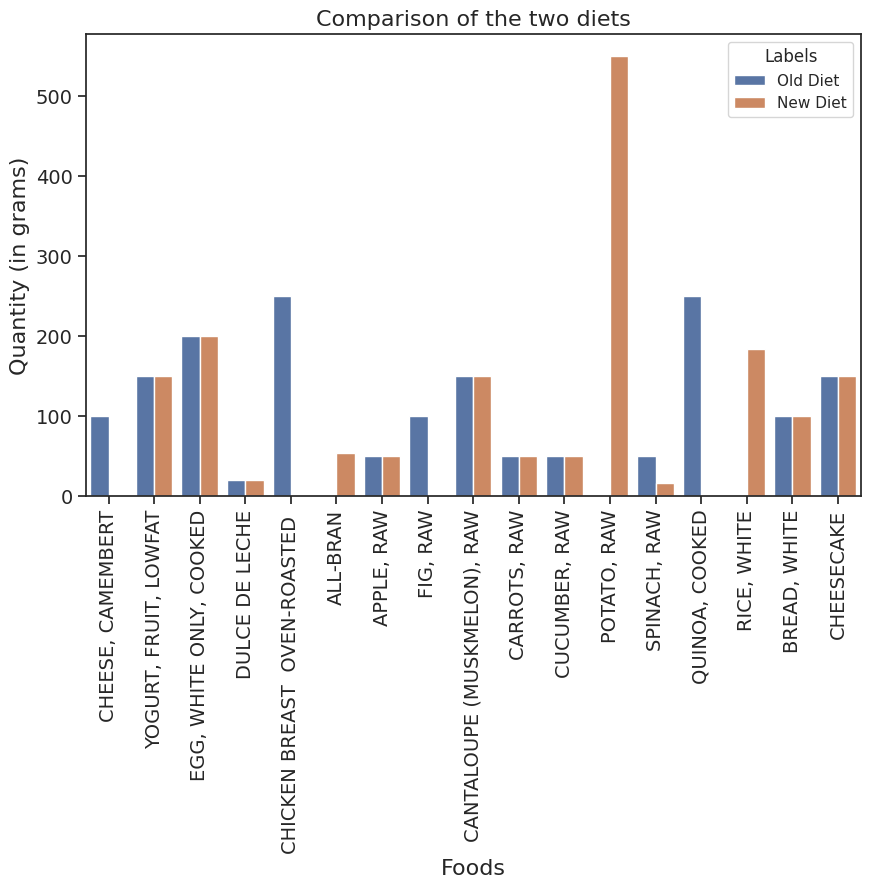

In [19]:
#@title Construct the model
daily_Budget = 5 # daily budget of $5

# create an empty model
myModel_Q5b = Model("Optimal Diet Problem with RDA and TUL")

# decision variables for the quantities consumed
quantity_consumed_Q5b = myModel_Q5b.addVars(all_foods, lb = 0.0, name = "Food")

# decision variables for the absolute difference
abs_differences = myModel_Q5b.addVars(all_foods)

# calculate and add the objective: minimize total squared difference
total_difference = quicksum(abs_differences[f] for f in all_foods)
myModel_Q5b.setObjective(total_difference, GRB.MINIMIZE)

# calculate the cost and add a constraint
cost_Q5b = quicksum( quantity_consumed_Q5b[f]*foodData.loc[f,"Price_($)"] for f in all_foods)
myModel_Q5b.addConstr( cost_Q5b <= daily_Budget )

# add constraints for RDAs
for n in nutrients_with_RDA :
    myModel_Q5b.addConstr(  quicksum( quantity_consumed_Q5b[f]*foodData.loc[f,n] for f in all_foods ) \
                      >= RDA[n][Marco_life_stage], name = "RDA_{}".format(n))

# constraints for absolute differences
for f in all_foods:
    myModel_Q5b.addConstr( abs_differences[f] >= quantity_consumed_Q5b[f] - foodData.loc[f,"Marco_Diet"] )
    myModel_Q5b.addConstr( abs_differences[f] >= foodData.loc[f,"Marco_Diet"] - quantity_consumed_Q5b[f] )

#@markdown - select whether to run the optimization algorithms silently (no outputs)
run_silently = True #@param {type:"boolean"}

if run_silently:
    myModel_Q5b.setParam('OutputFlag',0)
else:
    myModel_Q5b.setParam('OutputFlag',1)

print("Done creating the model.")
print("Proceeding to solve...")

myModel_Q5b.optimize()

# print differences
print("\nTotal difference from Marco's diet (in grams): {:.3f}.\n".\
      format(myModel_Q5b.objVal))

print("\nHere are the old and the new diet side-by-side:")
tol = 0.0001   # tolerance: if the diet includes an amount LESS than this, we won't count it in!
foods_with_differences = []
names_foods_with_differences = []
new_diet_values = []
old_diet_values = []

for f in all_foods:
  if (quantity_consumed_Q5b[f].X > tol) or (foodData["Marco_Diet"][f] > tol) :
     foods_with_differences += [f]
     names_foods_with_differences += [foodData["Main_food_description"][f]]
     new_diet_values += [ quantity_consumed_Q5b[f].X*100]
     old_diet_values += [foodData.loc[f,"Marco_Diet"]*100]

df_differences_Q5b = pd.DataFrame.from_dict( {"Food" : foods_with_differences, \
                                             "Name" : names_foods_with_differences,\
                                             "Old Diet" : old_diet_values,\
                                             "New Diet" : new_diet_values
                                             } )
# print the dataframe
pd.set_option('display.max_rows', df_differences_Q5b.shape[0]+1)
print(df_differences_Q5b.to_string(index=False))

#@markdown - select whether to plot the differences
plot_differences = True #@param {type:"boolean"}

if plot_differences:
    sns.color_palette("muted")
    sns.set(style="ticks")
    df_to_plot = pd.melt(df_differences_Q5b, id_vars=['Food', "Name"], \
                        value_vars=["Old Diet",	"New Diet"], \
                        var_name='Labels', value_name='Values')

    f, ax = plt.subplots(figsize=(10, 6))

    # use next two lines if you prefer horizontal orientation instead of vertical
    #ax.set_xscale("log")
    #sns.barplot(y="Nutrient", x="Values", hue="Labels", data=df_to_plot, orient="h")

    sns.barplot(x="Name", y="Values", hue="Labels", data=df_to_plot, orient="v")
    plt.xticks(rotation=90)
    #for tick in ax.get_xticklabels():
    #    tick.set_rotation(90)

    ax.set_ylabel('Quantity (in grams)',fontsize=16)
    ax.set_xlabel('Foods',fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    f = ax.set_title('Comparison of the two diets', fontsize=16)